In [4]:
import csv
import os
from os import path
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

First we will be reading and cleaning the data in the taylor_album_songs csv. We will be removing columns that aren't needed for our analysis and renaming different values so they match up with taylor_lyrics CSV to make merging easier. We will be saving this to a new CSV called 'cleaned_album_data' so our original data is still available to reference if we need it.

In [37]:
# Define relative filepath in a subdirectory
file_path = "data/taylor_album_songs.csv"
data_directory = 'data'
os.makedirs(data_directory, exist_ok=True)

# Read file
data_taylor_album_songs = pd.read_csv(file_path)

# Clean data and create a new csv
columns_to_drop = ['artist_name', 'artist_id', 'album_id', 'album_release_year', 'album_release_date_precision', 'album_type', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'track_id', 'track_number', 'type', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'disc_number', 'duration_ms', 'track_preview_url', 'track_uri', 'external_urls.spotify', 'key_name', 'mode_name', 'key_mode', 'track_href', 'is_local', 'analysis_url']
data_taylor_album_songs.drop(columns=columns_to_drop, axis=1, inplace=True)
values_to_keep = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", "Red (Taylor's Version)", "1989 (Deluxe)", "reputation", "Lover", "folklore (deluxe version)", "evermore (deluxe version)", "Midnights (3am Edition)"]
data_taylor_album_songs = data_taylor_album_songs[data_taylor_album_songs['album_name'].isin(values_to_keep)]

cleaned_album_data = data_taylor_album_songs
cleaned_album_data.rename(columns = {'album_release_date': 'Release Date', 'explicit': 'Explicit', 'track_name': 'Song Title', 'album_name': 'Album', 'lyrics': 'Lyrics' }, inplace=True)
cleaned_album_data['Album'].replace({'Taylor Swift': 'Taylor Swift (Deluxe)'}, inplace=True)
cleaned_album_data = cleaned_album_data[['Album', 'Release Date', 'Explicit', 'Song Title']]
songs_to_drop = ["Speak Now (Taylor’s Version) [Prologue]", "A Message From Taylor", "Taylor Swift’s First Phone Call With Tim McGraw", "I Know Places (Voice Memo)", "I Wish You Would (Voice Memo)",  "Blank Space (Voice Memo)", "If You’re Anything Like Me [Poem]", "Why She Disappeared [Poem]", "Reputation [Prologue]", "Evermore [Liner Notes]", "​​folklore [Foreword]", "Forever & Always (Piano Version) [Taylor’s Version]", "Love Story (Taylor’s Version) [Elvira Remix]",  "State Of Grace (Acoustic Version) (Taylor’s Version)"]
rows_to_drop = cleaned_album_data['Song Title'].isin(songs_to_drop)

# Save to CSV
cleaned_album_data.to_csv('data/cleaned_album_data.csv', index=False)


We will be doing a similar process for the taylor_lyrics CSV below:

In [617]:
# Define relative filepath in a subdirectory
file_path = "data/taylor_lyrics.csv"

# Read file
data_taylor_lyrics = pd.read_csv(file_path)

#Clean data and create new csv
cleaned_lyric_data = data_taylor_lyrics

#Remove duplicate tracks and spoken/non-songs
songs_to_drop = ["Speak Now (Taylor’s Version) [Prologue]", "A Message From Taylor", "Taylor Swift’s First Phone Call With Tim McGraw", "I Know Places (Voice Memo)", "I Wish You Would (Voice Memo)",  "Blank Space (Voice Memo)", "If You’re Anything Like Me [Poem]", "Why She Disappeared [Poem]", "Reputation [Prologue]", "Evermore [Liner Notes]", "folklore [Foreward]", "Forever & Always (Piano Version) [Taylor’s Version]", "Love Story (Taylor’s Version) [Elvira Remix]",  "State Of Grace (Acoustic Version) (Taylor’s Version)"]
rows_to_drop = cleaned_lyric_data['Song Title'].isin(songs_to_drop)
columns_to_drop = ["Featured Artists"]
data_taylor_lyrics.drop(columns=columns_to_drop, axis=1, inplace=True)
cleaned_lyric_data = cleaned_lyric_data[~rows_to_drop]

# Save to CSV
cleaned_lyric_data.to_csv('data/cleaned_lyric_data.csv', index=False)

Now that we have cleaned both CSVs and saved new versions, it's time to merge. After merging we will rearrange the order of the columns so the 'Lyrics' column is last. This makes the dataframe easier to read since each value in the 'Lyrics' column is so long. We will then save to a new csv called merged_taylor_data.

In [620]:
# Reload cleaned data
cleaned_album_data = pd.read_csv('data/cleaned_album_data.csv')
cleaned_lyric_data = pd.read_csv('data/cleaned_lyric_data.csv')

# Merge
merged_data = cleaned_lyric_data.merge(
    cleaned_album_data[['Album', 'Release Date', 'Song Title', 'Explicit']],
    on=['Album', 'Release Date', 'Song Title'],
    how='left'
)

# Fill NaN values in 'Explicit' with values from cleaned_album_data
merged_data['Explicit'].fillna(cleaned_album_data['Explicit'], inplace=True)

# Rearrange columns
column_order = ['Album', 'Release Date', 'Song Title', 'Explicit', 'Lyrics']
merged_data = merged_data[column_order]

# Save to a new CSV file
merged_data.to_csv('data/merged_taylor_data.csv', index=False)

Taylor Swift references color a lot in her songs both as a descriptor and metaphorically, so I was interested to see which colors were referenced most often. To do this we will create a bar graph. We will then need to adjust the figure size so the x axis is easier to read. 

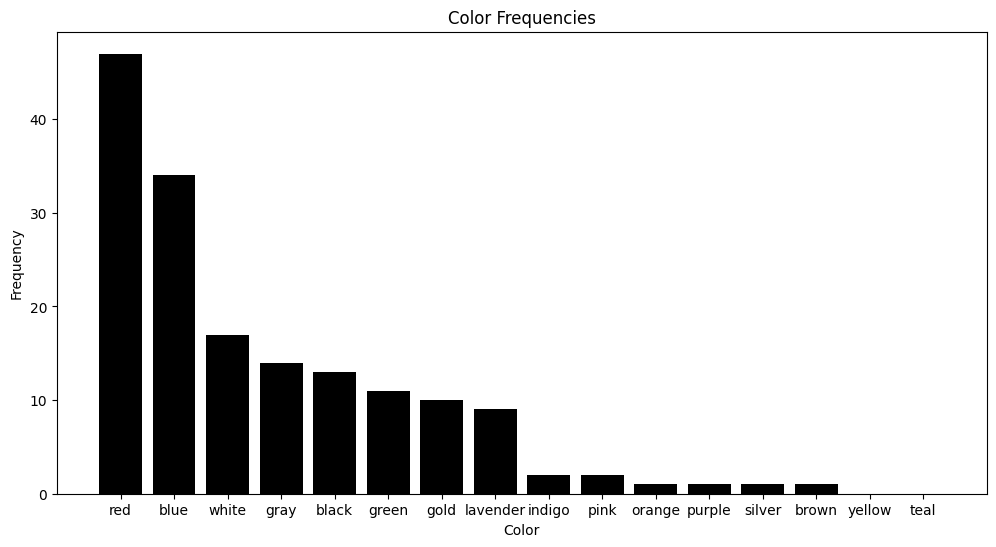

In [13]:
# Load cleaned lyric data
cleaned_lyric_data = pd.read_csv('data/cleaned_lyric_data.csv')

# Combine all lyrics into a single string
all_lyrics = ' '.join(cleaned_lyric_data['Lyrics'].dropna())

# Specify words of interest
words_of_interest = ['red', 'orange', 'blue', 'green', 'yellow', 'indigo', 'purple', 'pink', 'white', 'black', 'gray', 'lavender', 'teal', 'gold', 'silver', 'brown']
word_frequencies = {word: tokens.count(word) for word in words_of_interest}
sorted_word_frequencies = dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True))

# Change color of bars in graph
colors = ['black']

# Change figure size so it is easier to read
plt.figure(figsize=(12, 6))

# graph
plt.bar(sorted_word_frequencies.keys(), sorted_word_frequencies.values(), color=colors)
plt.title('Color Frequencies')
plt.xlabel('Color')
plt.ylabel('Frequency')
plt.show()

Next I wanted to see what percentage of Taylor Swift's songs had explicit lyrics vs. non-explicit lyrics. This chart pulls information from the "Explicit" column in merged_taylor_data. To make it easier to read we will change the values "true" and "false" to "explicit" and "non-explicit", respectively.

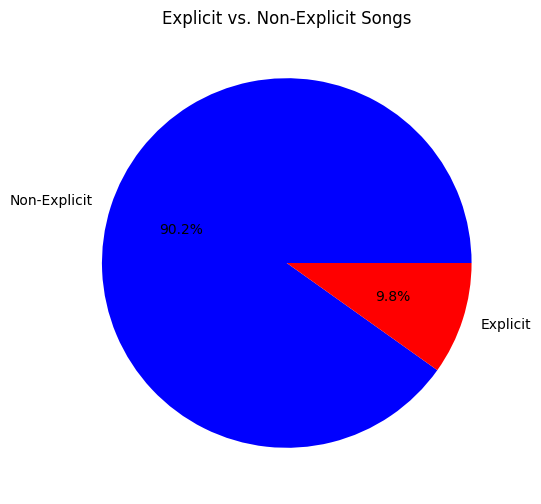

In [32]:
# Load data
merged_data = pd.read_csv('data/merged_taylor_data.csv')

# Count the number of True and False values in the "Explicit" column
explicit_counts = merged_data['Explicit'].value_counts()

# Map true/false values to explicit/non-explicit
merged_data['Explicit_Label'] = merged_data['Explicit'].map({True: 'Explicit', False: 'Non-Explicit'})

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(explicit_counts, labels=['Non-Explicit', 'Explicit'], autopct='%1.1f%%', colors=['blue', 'red'])
plt.title('Explicit vs. Non-Explicit Songs')
plt.show()